In [1]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
musicbox_conn = sql.connect("../data/musicbox.sqlite")
musicbox_conn.text_factory = str

In [3]:
pd.read_sql("SELECT * FROM sqlite_master", musicbox_conn)

,type,name,tbl_name,rootpage,sql
0,table,Down,Down,3,"CREATE TABLE Down(\n uid INT,\n device TEXT,..."
1,table,Play,Play,4,"CREATE TABLE Play(\n uid INT,\n device TEXT,..."
2,index,song_id_index,Play,6,CREATE INDEX song_id_index ON Play (song_id)
3,index,songid_songlength_idx,Play,5,CREATE INDEX songid_songlength_idx ON Play (so...
4,table,song_info,song_info,7,"CREATE TABLE ""song_info"" (\n""song_id"" REAL,\n ..."
5,index,song_id_name_idx,song_info,8,CREATE INDEX song_id_name_idx ON song_info(son...


### Drop paid_flag
sqlite doesn't support alter table ... drop ...

In [ ]:
musicbox_conn.execute("ALTER TABLE Down RENAME TO temp_down")

musicbox_conn.execute("""
CREATE TABLE Down AS
    SELECT uid, device, song_id, song_name, singer, date 
    FROM temp_down
""")

musicbox_conn.execute("DROP TABLE temp_down")

In [ ]:
%%time
musicbox_conn.execute("ALTER TABLE Play RENAME TO temp_play")

musicbox_conn.execute("""
CREATE TABLE Play AS
    SELECT uid, device, song_id, song_type, song_name, singer, play_time, song_length, date 
    FROM temp_play
""")

musicbox_conn.execute("DROP TABLE temp_play")

### Extract the date from original 'date' field

In [9]:
musicbox_conn.execute("ALTER TABLE Down RENAME TO temp_down")

musicbox_conn.execute("""
CREATE TABLE Down AS
    SELECT uid, device, song_id, song_name, singer, DATE(date) AS date 
    FROM temp_down
""")

musicbox_conn.execute("DROP TABLE temp_down")

In [17]:
#musicbox_conn.execute("ALTER TABLE Play RENAME TO temp_play")

musicbox_conn.execute("""
CREATE TABLE Play AS
    SELECT uid, device, song_id, song_type, song_name, singer, play_time, song_length, DATE(date) AS date 
    FROM temp_play
""")

musicbox_conn.execute("DROP TABLE temp_play")

In [ ]:
musicbox_conn.execute("VACUUM;")

### SET index

In [ ]:
# create index on uid in Play
musicbox_conn.execute("CREATE INDEX uid_index ON Play (uid);")

In [25]:
# create index on song_id
musicbox_conn.execute("CREATE INDEX song_id_index ON Play (song_id);")

In [ ]:
musicbox_conn.execute("CREATE INDEX device_index ON Down (device);")

## song_length and play_time
There are too many outliers (0, negative, NA, ridiculously large value) in song_length and play_time which cannot be neglected. For example, 22385091 play records with 0 song_length, which accounts for more than 10% data. Therefore, it is necessary to impute those outliers/missing values.

My strategy is 
1. Only 82115 records have no song_id, only 309 records have negative play_time, only 3813 records have no song_name, Delete those records.
2. 


In [5]:
musicbox_conn.execute("DELETE FROM Play WHERE song_id IS NULL OR play_time < 0")
musicbox_conn.execute("VACUUM;")

In [96]:
musicbox_conn.execute("DELETE FROM Play WHERE song_name IS NULL")
musicbox_conn.execute("VACUUM;")

In [123]:
# Odd...
musicbox_conn.execute("DELETE FROM Play WHERE song_name = '';") # 13
musicbox_conn.execute("VACUUM;")

In [14]:
musicbox_conn.execute("CREATE INDEX songid_songlength_idx ON Play (song_id, song_name, song_length);")

In [128]:
%%time
musicbox_conn.execute("""
CREATE TABLE song_info AS
    SELECT 
        song_id, song_name, song_length, MAX(count) AS max_count
    FROM
        (
        SELECT 
            song_id, song_name, song_length, COUNT(*) AS count 
        FROM 
            Play 
        GROUP BY 
            song_id, song_name, song_length
        ) sub
    WHERE
        song_length IS NOT NULL AND song_length != 0
    GROUP BY
        song_id, song_name
""")

CPU times: user 1min 28s, sys: 5.01 s, total: 1min 33s
Wall time: 1min 33s


In [4]:
song_info = pd.read_sql("SELECT * FROM song_info", musicbox_conn)

In [5]:
song_info.head()

,song_id,song_name,song_length,max_count
0,0.0,花雨,297.0,6
1,0.0,! 远飞的大雁,228.0,2
2,0.0,"!LAWKKLAWLAWHANMIN0,",124.0,6
3,0.0,!liaF cipE,201.0,6
4,0.0,!十劝人心 ---友谊科技,60.0,2


In [6]:
song_info.song_length.describe()

count    2.350533e+06
mean     3.906170e+02
std      5.813164e+02
min      1.000000e+00
25%      1.900000e+02
50%      2.420000e+02
75%      3.050000e+02
max      7.030000e+03
Name: song_length, dtype: float64

In [140]:
song_info.sort_values(['song_length'], ascending=False).head(15)

,song_id,song_name,song_length,max_count
2350692,129945935.0,汪苏泷-桃花扇,1.343966e+09,1
2350691,129945928.0,Isyana Sarasvati-Keep Being You,1.343966e+09,1
2350689,123575885.0,那家超市,3.993139e+08,1
2350702,132403174.0,薛之谦-演员,7.805389e+07,3
2350675,100991981.0,李玉刚 - 新贵妃醉酒,7.720602e+07,1
2350703,132493632.0,Don Diablo&Matt Nash-Starlight(Could You Be Mi...,6.257152e+07,1
2350695,131086700.0,给十五岁的自己,6.237286e+07,4
2350696,131283679.0,Hafan Feat. FathoM (Original Mix),6.144256e+07,6
2350694,130989725.0,陈奕迅 - 让我留在你身边,6.116659e+07,7
1972851,7042277.0,曼姐查房20160417直播回放,1.249582e+07,3


In [151]:
song_info[song_info.song_length == song_info.song_length.quantile(0.999)]

,song_id,song_name,song_length,max_count
9780,0.0,02-034-0015 - www.amtb.tw,7030.0,2
320917,0.0,佛号长,7030.0,2
2094914,9948338.0,文儿疯癫手指舞20161105上午直播回放,7030.0,7
2201735,14702701.0,曹云金-隋唐演义(第十一回),7030.0,7


In [152]:
(song_info.song_length > song_info.song_length.quantile(0.999)).mean()

0.00099919928054251726

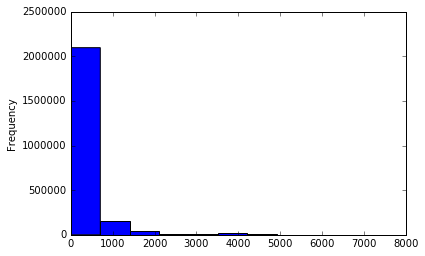

In [158]:
song_info.song_length[song_info.song_length <= song_info.song_length.quantile(0.999)].plot.hist()

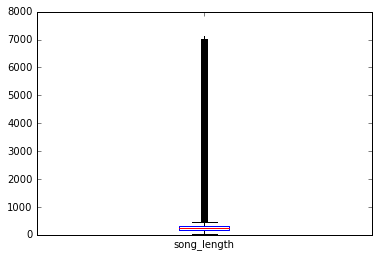

In [159]:
song_info.song_length[song_info.song_length <= song_info.song_length.quantile(0.999)].plot.box()

In [157]:
song_info.head()

,song_id,song_name,song_length,max_count
0,0.0,花雨,297.0,6
1,0.0,! 远飞的大雁,228.0,2
2,0.0,"!LAWKKLAWLAWHANMIN0,",124.0,6
3,0.0,!liaF cipE,201.0,6
4,0.0,!十劝人心 ---友谊科技,60.0,2


In [160]:
song_info = song_info[song_info.song_length <= song_info.song_length.quantile(0.999)]

In [163]:
song_info.to_sql("song_info", musicbox_conn, if_exists="replace", index=False)

In [165]:
pd.read_sql("SELECT * FROM song_info LIMIT 5", musicbox_conn)

,song_id,song_name,song_length,max_count
0,0.0,花雨,297.0,6
1,0.0,! 远飞的大雁,228.0,2
2,0.0,"!LAWKKLAWLAWHANMIN0,",124.0,6
3,0.0,!liaF cipE,201.0,6
4,0.0,!十劝人心 ---友谊科技,60.0,2


In [167]:
pd.read_sql("SELECT * FROM Play LIMIT 5", musicbox_conn)

,uid,device,song_id,song_type,song_name,singer,play_time,song_length,date
0,154422682,ar,20870993.0,1.0,用情,狮子合唱团,22013.0,332.0,2017-03-01
1,154421907,ip,6560858.0,0.0,表情不要悲伤,伯贤&D.O.&张艺兴&朴灿烈,96.0,161.0,2017-03-01
2,154422630,ar,3385963.0,1.0,"Baby, Don't Cry(人鱼的眼泪)",EXO,235868.0,235.0,2017-03-01
3,154410267,ar,6777172.0,0.0,3D-环绕音律1(3D Mix),McTaiM,164.0,237.0,2017-03-01
4,154407793,ar,19472465.0,0.0,刚好遇见你,曲肖冰,24.0,201.0,2017-03-01


should have set up index for song_info table?

In [7]:
musicbox_conn.execute("CREATE INDEX song_id_name_idx ON song_info(song_id, song_name)")

In [5]:
%%time
musicbox_conn.execute("""
CREATE TABLE Play_new AS
    SELECT
        p.uid, p.device, s.song_id, s.song_name, p.singer, p.play_time, s.song_length, p.date
    FROM
        song_info AS s
        LEFT JOIN
        Play AS p ON s.song_id = p.song_id AND s.song_name = p.song_name
""")

CPU times: user 13min 9s, sys: 38min 5s, total: 51min 14s
Wall time: 3h 30min 23s
